# Model Server Demo

This notebook demonstrates how to receive simulations from the server.

In [2]:
import requests
import json
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

In [3]:
def dec_img(response):
    """Decode numpy array from base64 encoded response"""
    import base64
    from io import BytesIO
    
    result = response.json()
    
    # Check for content field (from get_df endpoint)
    if 'content' in result:
        # Decode base64 to bytes
        content_bytes = base64.b64decode(result['content'])
        # Load numpy array from bytes
        return np.load(BytesIO(content_bytes))
    elif 'image' in result:
        # Decode base64 image
        img_data = base64.b64decode(result['image'])
        img = Image.open(BytesIO(img_data))
        return np.array(img)
    elif 'matrix' in result:
        # Return matrix as numpy array
        return np.array(result['matrix'])
    else:
        print("No content, image, or matrix found in response")
        return None


def decode_encoded_image(encode_response):
    """Decode base64-encoded image from /encode endpoint response
    
    Args:
        encode_response: Response from /encode endpoint containing base64-encoded images
        
    Returns:
        Dictionary mapping window names to PIL Images
    """
    import base64
    from io import BytesIO
    
    result = encode_response.json()
    
    if result.get("status") != "success":
        print(f"❌ Error in response: {result.get('error')}")
        return None
    
    images = {}
    results = result.get("results", {})
    
    for window_name, window_result in results.items():
        if window_result.get("status") == "success":
            # Decode base64 string to bytes
            encoded_b64 = window_result.get("encoded_image")
            image_bytes = base64.b64decode(encoded_b64)
            
            # Convert bytes to PIL Image
            img = Image.open(BytesIO(image_bytes))
            images[window_name] = img
            
            print(f"✅ Decoded image for '{window_name}': {img.size}, {img.mode}")
        else:
            print(f"❌ Error for '{window_name}': {window_result.get('error')}")
    
    return images


print("✅ Helper functions loaded")

✅ Helper functions loaded


## Server Configuration

In [4]:
# Server configuration
PROD = False
SERVER_URL = "https://lux-server-jia3y72oka-ma.a.run.app" if PROD else "http://localhost:8081"

# Asset paths
SAMPLE_IMAGE_PATH = "../assets/sample.png"
RES_IMAGE_PATH = "../assets/res.png"
VALUES_NPY_PATH = "../assets/values.npy"

## Check Server Status

In [5]:
# Check if server is running
try:
    response = requests.get(f"{SERVER_URL}/")
    if response.status_code == 200:
        status = response.json()
        print("Server Status:")
        print(json.dumps(status, indent=2))
    else:
        print(f"Server returned status code: {response.status_code}")
except requests.exceptions.ConnectionError:
    print("❌ Server is not running. Please start the server first with: python src/main.py")
except Exception as e:
    print(f"❌ Error connecting to server: {e}")

Server Status:
{
  "services": {
    "colormanage_service": "ready",
    "daylight_service": "ready",
    "df_eval_service": "ready",
    "encoder_service": "ready",
    "http_client": "ready",
    "obstruction_service": "ready",
    "orchestration_service": "ready"
  },
  "status": "running"
}


## Example Requests

### 🫧 get_df - Get Daylight Factor from Image

In [5]:
# Send get_df request
with open(SAMPLE_IMAGE_PATH, "rb") as f:
    files = {"file": ("sample.png", f)}
    df_response = requests.post(
        f"{SERVER_URL}/get_df",
        files=files,
        data={
            "translation": json.dumps({"x": 15 * 50, "y": 0 * 50}),
            "rotation": json.dumps([0])
        }
    )

df_result = dec_img(df_response)

No content, image, or matrix found in response


In [ ]:
plt.imshow(df_result, cmap='viridis')

### 🫧 to_rgb 
##### Convert Values to RGB

In [ ]:
# Send to_rgb request
values_data = np.load(VALUES_NPY_PATH)
rgb_response = requests.post(
    f"{SERVER_URL}/to_rgb",
    json={"data": values_data.tolist(), "colorscale": "df"}
)

rgb_result = np.array(rgb_response.json()["data"])

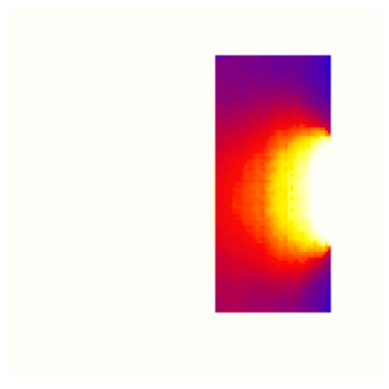

In [29]:
# Visualize result
plt.imshow(rgb_result)
plt.axis('off')
plt.show()

### 🫧 to_values 
##### Conversion of RGB into raw values


In [30]:
res_img = Image.open(RES_IMAGE_PATH)
res_array = np.array(res_img)

values_response = requests.post(
    f"{SERVER_URL}/to_values",
    json={"data": res_array.tolist(), "colorscale": "df"}
)

values_result = np.array(values_response.json()["data"])

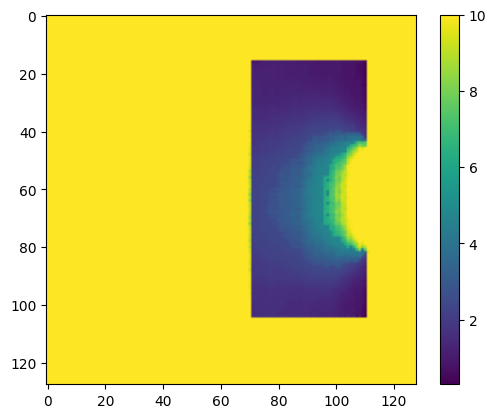

In [31]:
# Visualize result
plt.imshow(values_result, cmap='viridis')
plt.colorbar()
plt.show()

### 🫧 get_stats 
##### get statistics

In [32]:
# Send get_stats request
stats_response = requests.post(
    f"{SERVER_URL}/get_stats",
    json={"data": values_data.tolist()}
)

stats_result = stats_response.json()

In [33]:
# Display result
print(json.dumps(stats_result, indent=2))

{
  "error": "403 Client Error: Forbidden for url: https://df-eval-server-jia3y72oka-ma.a.run.app/get_stats",
  "status": "error"
}


### 🫧 encode 
##### Encode room parameters to image (Protected Endpoint)

In [ ]:
# Define the complete request payload
API_TOKEN = ""

headers = {
    "Authorization": f"Bearer {API_TOKEN}",
    "Content-Type": "application/json"
}

run_payload = {
    "model_type": "df_default",
    "parameters": {
        "height_roof_over_floor": 2.7,
        "floor_height_above_terrain": 3.0,
        "room_polygon": [[0, 0], [5, 0], [5, 4], [0, 4]],
        "windows": {
            "main_window": {
                "x1": -0.6, "y1": 0.0, "z1": 0.9,
                "x2": 0.6, "y2": 0.0, "z2": 2.4,
                "window_sill_height": 0.9,
                "window_frame_ratio": 0.15,
                "window_height": 1.5,
                "direction_angle": 0.5,
            }
        }
    },
    "mesh": [
        [10, 0, 0], [10, 0, 5],
        [10, 10, 5], [10, 10, 0]
    ],
    "translation": {"x": 750, "y": 0},
    "rotation": [0]
}

# Send /run request
run_response = requests.post(
    f"{SERVER_URL}/run",
    json=run_payload,
    headers=headers
)

if run_response.status_code == 200:
    result = run_response.json()
    print("✅ Complete workflow executed successfully!")
    print(f"Status: {result.get('status')}")
    
    # Decode and visualize if content is returned
    if 'content' in result:
        df_result = dec_img(run_response)    
    elif 'data' in result:
        df_result = np.array(result['data'])
    plt.figure(figsize=(10, 8))
    plt.imshow(df_result, cmap='viridis')
    plt.colorbar(label='Daylight Factor')
    plt.title('Daylight Simulation Result')
    plt.axis('off')
    plt.show()
else:
    print(f"❌ Error: {run_response.status_code}")
    try:
        error = run_response.json()
        print(f"Error message: {error.get('error')}")
    except:
        print(run_response.text)

❌ Error: 404
<!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>



### 🫧 run 
##### Complete workflow: obstruction → encoding → simulation

In [77]:
# NOTE: This endpoint requires authentication
# Set your API token here (should be same as API_TOKEN environment variable on server)
API_TOKEN = "your_api_token_here"

headers = {
    "Authorization": f"Bearer {API_TOKEN}",
    "Content-Type": "application/json"
}

payload = {
    "model_type": "df_default",
    "parameters": {
        "height_roof_over_floor": 2.7,
        "floor_height_above_terrain": 3.0,
        "room_polygon": [[0, 0], [5, 0], [5, 4], [0, 4]],
        "windows": {
            "main_window": {
                "x1": -0.6, "y1": 0.0, "z1": 0.9,
                "x2": 0.6, "y2": 0.0, "z2": 2.4,
                "window_sill_height": 0.9,
                "window_frame_ratio": 0.15,
                "window_height": 1.5,
                "obstruction_angle_horizon": 15.0,
                "obstruction_angle_zenith": 10.0
            }
        },
        
    },
    "mesh":[]
}

# Send encode request
encode_response = requests.post(
    f"{SERVER_URL}/encode",
    headers=headers,
    json=payload
)

if encode_response.status_code == 200:
    # Save the encoded image
    with open("encoded_room.png", "wb") as f:
        f.write(encode_response.content)
    print("✅ Encoded image saved successfully to encoded_room.png")
    
    # Display the image
    encoded_img = Image.open("encoded_room.png")
    plt.imshow(encoded_img)
    plt.axis('off')
    plt.title("Encoded Room Image")
    plt.show()
else:
    print(f"❌ Error: {encode_response.status_code}")
    try:
        print(encode_response.json())
    except:
        print(encode_response.text)

❌ Error: 500
{'error': 'Mesh must contain at least 3 points', 'status': 'error'}


## 🫧Test Remote Server

In [6]:
SERVER_URL = "http://51.15.197.220:8081"# "https://obstruction-server-jia3y72oka-ma.a.run.app"

### 🫧 obstruction_parallel (Server-Side Parallelization)
##### Uses the server's parallel obstruction calculation service

In [9]:
import time

API_TOKEN = ""
# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"

# Load sample request
with open("../assets/sample2/window_4952383_request.json", "r") as f:
    obstruction_request = json.load(f)

print(f"Sending request to {SERVER_URL}/obstruction_parallel")
print(f"Mesh size: {len(obstruction_request['mesh'])} triangles")
print(f"Window position: ({obstruction_request['x']:.2f}, {obstruction_request['y']:.2f}, {obstruction_request['z']:.2f})")

# Send request and time it
start_time = time.time()
response = requests.post(f"{SERVER_URL}/obstruction_parallel", json=obstruction_request, headers=headers, timeout=300)
elapsed_time = time.time() - start_time

print(f"\nResponse status: {response.status_code}")
print(f"Total time: {elapsed_time:.2f}s")

if response.status_code == 200:
    parallel_result = response.json()
    
    if parallel_result.get("status") == "success":
        try:
            horizon_angles = parallel_result["horizon_angles"]
            zenith_angles = parallel_result["zenith_angles"]
        except Exception:
            # Extract angles from the returned structure
            results = parallel_result.get("data", {}).get("results", [])
            horizon_angles = np.array([r.get("horizon", {}).get("obstruction_angle_degrees", 0.0) for r in results])
            zenith_angles = np.array([r.get("zenith", {}).get("obstruction_angle_degrees", 0.0) for r in results])
        print(f"\n✅ SUCCESS! Calculated obstruction for 64 directions")
        print(f"\nHorizon angles ({len(horizon_angles)} values):")
        # print(f"  Min: {min(horizon_angles):.2f}°, Max: {max(horizon_angles):.2f}°, Mean: {np.mean(horizon_angles):.2f}°")
        print(f"\nZenith angles ({len(zenith_angles)} values):")
        print(f"  Min: {min(zenith_angles):.2f}°, Max: {max(zenith_angles):.2f}°, Mean: {np.mean(zenith_angles):.2f}°")
        
        # Save for visualization
        obstruction_parallel_result = parallel_result
    else:
        print(f"\n❌ Error: {parallel_result.get('error')}")
else:
    print(f"\n❌ HTTP Error {response.status_code}: {response.text[:200]}")

Sending request to http://51.15.197.220:8081/obstruction_parallel
Mesh size: 60114 triangles
Window position: (39.98, 48.78, 18.65)

Response status: 200
Total time: 5.74s

✅ SUCCESS! Calculated obstruction for 64 directions

Horizon angles (64 values):

Zenith angles (64 values):
  Min: 0.00°, Max: 0.00°, Mean: 0.00°


In [10]:
SERVER_URL = "http://127.0.0.1:8081"

### /encode

In [31]:
API_TOKEN = ""
# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"

# Load sample request
# with open("../assets/sample2/window_4952383_request.json", "r") as f:
#     r = json.load(f)

obstruction_request = {
            "model_type": "df_default", 
            "parameters": {
                "height_roof_over_floor": 19.7,
                "floor_height_above_terrain": 2.71,
                "room_polygon": [[0, 0], [0, 7], [-3, 7], [-3, 0]],
                "windows": {
                    "test_window": {
                        "x1": 0, "y1": 1, "z1": 2.8,
                        "x2": 0.4, "y2": 4.8, "z2": 5.4,
                        "window_frame_ratio": 0.41,
                        "direction_angle": 0,
                        "obstruction_angle_horizon": [0 for a in horizon_angles],
                        "obstruction_angle_zenith": [0 for a in zenith_angles]
                    },
                    "test_window_1": {
                        "x1": -0.4, "y1": 7, "z1": 2.8,
                        "x2": -2, "y2": 7.3, "z2": 5.4,
                        "window_frame_ratio": 0.41,
                        "direction_angle": 1.5708,
                        "obstruction_angle_horizon": [30 for a in horizon_angles],
                        "obstruction_angle_zenith": [30 for a in zenith_angles]
                    }
                }
            },
            "mesh": r["mesh"][:180]
        }

# obstruction_request["model_type"] = "df_default_2.0.1"
print(f"Sending request to {SERVER_URL}/run")
print(f"Mesh size: {len(obstruction_request['mesh'])} triangles")
# print(f"Window position: ({obstruction_request['x']:.2f}, {obstruction_request['y']:.2f}, {obstruction_request['z']:.2f})")

# Send request and time it
start_time = time.time()
response = requests.post(f"{SERVER_URL}/run", json=obstruction_request, headers=headers, timeout=300)
elapsed_time = time.time() - start_time

print(f"\nResponse status: {response.status_code}")
print(f"Total time: {elapsed_time:.2f}s")

if response.status_code == 200:
    res = response.json()
    
    if res.get("status") == "success":
        # Extract angles from the returned structure
        print(res)
    else:
        print(f"\n❌ Error: {parallel_result.get('error')}")
else:
    print(f"\n❌ HTTP Error {response.status_code}: {response.text[:200]}")

Sending request to http://127.0.0.1:8081/run
Mesh size: 180 triangles

Response status: 200
Total time: 7.60s
{'merged_result': {'df_matrix': [[1.164941430091858, 4.303040981292725, 4.673217296600342, 4.984116554260254, 5.003115653991699, 5.004635334014893, 5.1388444900512695, 5.183453559875488, 4.839496612548828, 4.173696041107178, 3.21219539642334, 2.3155956268310547, 2.256546974182129, 2.2008419036865234, 2.1468088626861572, 2.061161518096924, 2.102579116821289, 2.1928622722625732, 2.4526925086975098, 2.592525005340576, 2.688279628753662, 2.8046295642852783, 2.7928500175476074, 2.586597204208374, 2.457252025604248, 2.2892251014709473, 2.3901476860046387, 2.9896795749664307, 4.2936177253723145, 4.163588523864746], [5.095450401306152, 4.644186973571777, 4.711291313171387, 5.111105918884277, 5.436140060424805, 5.597631454467773, 5.782453536987305, 5.656376361846924, 4.967625617980957, 3.9234414100646973, 2.7495322227478027, 2.5209367275238037, 2.44828462600708, 2.3746447563171387, 2.33

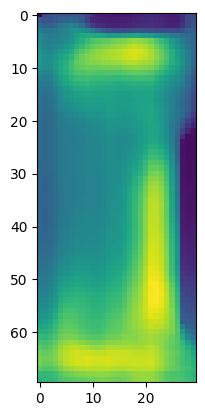

In [32]:
res = response.json()
img = res["merged_result"]
plt.imshow(np.array(img["df_matrix"]))

In [19]:
out = Path("window_results.json")
with out.open("w") as f:
    json.dump(res["window_results"], f, indent=2, default=lambda o: o.tolist() if hasattr(o, "tolist") else str(o))
print(f"Saved window_results to {out}")

Saved window_results to window_results.json


In [ ]:
{
    100:1.18,
    180: 1,
    1000: 1.86,
    1800: 3.4,
    3000: 4.07,
    5000: 6.18,
    10000: 9.99,
    18000: 21,
    30000: 34,
    40000: 46.3,
    50000: 52.73,
    60000: 66.35
}

In [34]:

# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"

# Load sample request
with open("../assets/sample2/window_4952383_request.json", "r") as f:
    r = json.load(f)

obstruction_request = {
            "model_type": "df_default",
            
            "parameters": {
                'invert_channels': False,
                "height_roof_over_floor": 19.7,
                "floor_height_above_terrain": 2.71,
                "room_polygon": [[0, 0], [0, 7], [-3, 7], [-3, 0]],
                "windows": {
                    "test_window": {
                        "x1": -0.7, "y1": 7, "z1": 3.71,
                        "x2": -2.1, "y2": 7.3, "z2": 5.4,
                        "window_frame_ratio": 0.15,
                        "direction_angle": 1.5708,
                        "obstruction_angle_horizon": [a for a in horizon_angles],
                        "obstruction_angle_zenith": [a for a in zenith_angles]
                    }
                }
            },
            "mesh": r["mesh"][:1800]
        }

# obstruction_request["model_type"] = "df_default_2.0.1"
print(f"Sending request to {SERVER_URL}/run")
print(f"Mesh size: {len(obstruction_request['mesh'])} triangles")
# print(f"Window position: ({obstruction_request['x']:.2f}, {obstruction_request['y']:.2f}, {obstruction_request['z']:.2f})")

# Send request and time it
start_time = time.time()
response = requests.post(f"{SERVER_URL}/run", json=obstruction_request, headers=headers, timeout=300)
elapsed_time = time.time() - start_time

print(f"\nResponse status: {response.status_code}")
print(f"Total time: {elapsed_time:.2f}s")

if response.status_code == 200:
    res = response.json()
    
    if res.get("status") == "success":
        # Extract angles from the returned structure
        print(res)
    else:
        print(f"\n❌ Error: {parallel_result.get('error')}")
else:
    print(f"\n❌ HTTP Error {response.status_code}: {response.text[:200]}")

Sending request to http://127.0.0.1:8081/run
Mesh size: 1800 triangles

Response status: 200
Total time: 7.55s
{'merger_error': 'Failed to connect to merge service at http://localhost:8084/merge', 'status': 'success', 'window_results': {'test_window': {'result': {'prediction': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

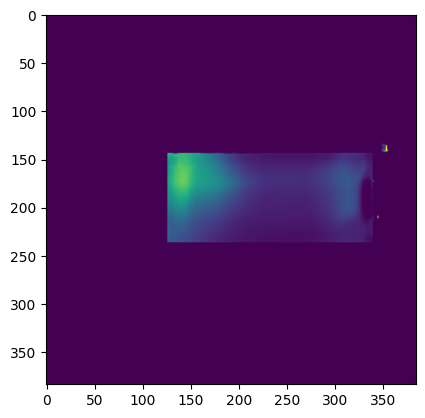

In [35]:
pred = res["window_results"]["test_window"]["result"]["prediction"]
plt.imshow(np.array(pred))

In [36]:
cv2.imwrite("test_window_2.png", np.array(pred))

True

In [71]:

# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"

# Load sample request
with open("../assets/sample2/window_4952383_request.json", "r") as f:
    r = json.load(f)

obstruction_request = {
  "image_array": ii.astype(int).tolist(),
  "invert_channels": True
}

start_time = time.time()
response = requests.post(f"{SERVER_URL}/get_df_direct", json=obstruction_request, headers=headers, timeout=300)
elapsed_time = time.time() - start_time

print(f"\nResponse status: {response.status_code}")
print(f"Total time: {elapsed_time:.2f}s")

if response.status_code == 200:
    res = response.json()
    
    if res.get("status") == "success":
        # Extract angles from the returned structure
        print(res)
    else:
        print(f"\n❌ Error: {parallel_result.get('error')}")
else:
    print(f"\n❌ HTTP Error {response.status_code}: {response.text[:200]}")


Response status: 200
Total time: 3.18s
{'prediction': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

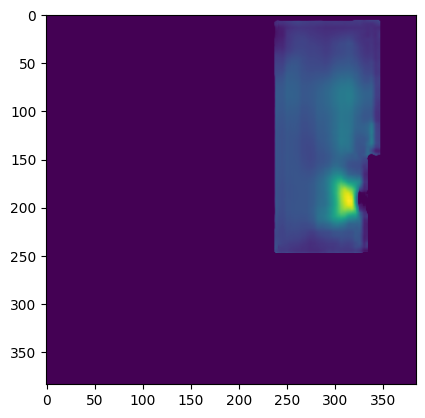

In [72]:
pred = res["prediction"]
plt.imshow(np.array(pred))

### 🫧 /encode - Test Encoding with Obstruction Angles
##### Test the encoder with obstruction angle arrays

In [1]:
# First get obstruction angles from obstruction_parallel
import time

with open("../assets/sample2/window_4952383_request.json", "r") as f:
    obstruction_request = json.load(f)

print("Step 1: Getting obstruction angles...")
obstruction_response = requests.post(
    f"{SERVER_URL}/obstruction_parallel",
    json=obstruction_request,
    headers=headers,
    timeout=120
)

if obstruction_response.status_code != 200:
    print(f"❌ Obstruction request failed: {obstruction_response.status_code}")
    print(obstruction_response.text)
else:
    obstruction_result = obstruction_response.json()
    
    if obstruction_result.get("status") == "success":
        results = parallel_result.get("data", {}).get("results", [])
        horizon_angles = np.array([r.get("horizon", {}).get("obstruction_angle_degrees", 0.0) for r in results])
        zenith_angles = np.array([r.get("zenith", {}).get("obstruction_angle_degrees", 0.0) for r in results])
        print(f"\n✅ SUCCESS! Calculated obstruction for 64 directions")
        print(f"\nHorizon angles ({len(horizon_angles)} values):")
        print(f"  Min: {min(horizon_angles):.2f}°, Max: {max(horizon_angles):.2f}°, Mean: {np.mean(horizon_angles):.2f}°")
        print(f"\nZenith angles ({len(zenith_angles)} values):")
        print(f"  Min: {min(zenith_angles):.2f}°, Max: {max(zenith_angles):.2f}°, Mean: {np.mean(zenith_angles):.2f}°")
        
        # Save for visualization
        obstruction_parallel_result = parallel_result
        
        encode_payload = {
            "model_type": "df_default",
            "parameters": {
                "height_roof_over_floor": 2.7,
                "floor_height_above_terrain": 3.0,
                "room_polygon": [[0, 0], [5, 0], [5, 4], [0, 4]],
                "windows": {
                    "test_window": {
                        "x1": 0.2, "y1": 0.0, "z1": 0.9,
                        "x2": 2, "y2": 0.0, "z2": 2.4,
                        "window_sill_height": 0.9,
                        "window_frame_ratio": 0.15,
                        "window_height": 1.5,
                        "rad_x": 0.5,
                        "rad_y": 0.5,
                        "obstruction_angle_horizon": horizon_angles.tolist(),
                        "obstruction_angle_zenith": zenith_angles.tolist()
                    }
                }
            }
        }
        
        print(f"Sending encode request with:")
        print(f"  - obstruction_angle_horizon: type={type(horizon_angles)}, len={len(horizon_angles)}")
        print(f"  - obstruction_angle_zenith: type={type(zenith_angles)}, len={len(zenith_angles)}")
        
        encode_response = requests.post(
            f"{SERVER_URL}/encode",
            json=encode_payload,
            headers=headers,
            timeout=30
        )
        
        print(f"\nEncode response status: {encode_response.status_code}")
        
        if encode_response.status_code == 200:
            print(f"✅ Encoding successful!")
            print(f"   Response size: {len(encode_response.content)} bytes")
            print(f"   Content-Type: {encode_response.headers.get('Content-Type')}")
            
            # Save and display the encoded image
            with open("test_encoded.png", "wb") as f:
                f.write(encode_response.content)
             
            img = Image.open("test_encoded.png")
            plt.figure(figsize=(10, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title('Encoded Room Image with Obstruction Angles')
            plt.show()
        else:
            print(f"❌ Encoding failed!")
            try:
                error = encode_response.json()
                print(f"   Error: {error}")
            except:
                print(f"   Response: {encode_response.text[:500]}")
    else:
        print(f"❌ Obstruction calculation failed: {obstruction_result.get('error')}")

NameError: name 'json' is not defined

### 🎨 Simple /encode Example
##### Encode room parameters directly to PNG image (without obstruction angles)

In [ ]:
# Simple encode example - just send parameters, get PNG back
# SERVER_URL = "http://localhost:8081"

# Get API token from environment
import os
import math
API_TOKEN = os.getenv("API_TOKEN", "")

# Prepare headers with authorization
headers = {
    "Content-Type": "application/json",
}

if API_TOKEN:
    headers["Authorization"] = f"Bearer {API_TOKEN}"

# Define room and window parameters
# direction_angle: Normal to window's glazed surface facing outside (radians)
#   0 = East (+X), π/2 = North (+Y), π = West (-X), 3π/2 = South (-Y)
encode_payload = {
    "model_type": "df_default",
    "parameters": {
        "height_roof_over_floor": 2.7,
        "floor_height_above_terrain": 3.0,
        "room_polygon": [[0, 0], [5, 0], [5, 4], [0, 4]],
        "windows": {
            "main_window": {
                "x1": -0.6, "y1": 0.0, "z1": 0.9,
                "x2": 0.6, "y2": 0.0, "z2": 2.4,
                "window_sill_height": 0.9,
                "window_frame_ratio": 0.15,
                "window_height": 1.5,
                "direction_angle": 0.0  # 0 rad = East (+X direction)
            }
        }
    }
}

print("Sending encode request to local server...")
print(f"Window direction: {encode_payload['parameters']['windows']['main_window']['direction_angle']:.2f} rad = {math.degrees(encode_payload['parameters']['windows']['main_window']['direction_angle']):.1f}°")

encode_response = requests.post(
    f"{SERVER_URL}/encode",
    json=encode_payload,
    headers=headers,
    timeout=30
)

print(f"Response status: {encode_response.status_code}")

if encode_response.status_code == 200:
    print(f"✅ Encoding successful!")
    print(f"   Response size: {len(encode_response.content)} bytes")
    print(f"   Content-Type: {encode_response.headers.get('Content-Type')}")
    
    # Save and display the encoded image
    with open("simple_encoded.png", "wb") as f:
        f.write(encode_response.content)
    
    img = Image.open("simple_encoded.png")
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Encoded Room Image (Simple Example)')
    plt.show()
else:
    print(f"❌ Encoding failed!")
    try:
        error = encode_response.json()
        print(f"   Error: {error}")
    except:
        print(f"   Response: {encode_response.text[:500]}")

Sending encode request to local server...
Window direction: 0.00 rad = 0.0°
Response status: 500
❌ Encoding failed!
   Error: {'error': 'Missing required field: mesh', 'status': 'error'}


In [ ]:
# Test sending encoded image to model server
import time
from io import BytesIO

# Model server configuration
MODEL_SERVER_URL = "http://localhost:8083"

print("Step 1: Getting obstruction angles...")

# Load sample request
with open("../assets/sample2/window_4952383_request.json", "r") as f:
    obstruction_request = json.load(f)

# Get obstruction angles
obstruction_response = requests.post(
    f"{SERVER_URL}/obstruction_parallel",
    json=obstruction_request,
    headers=headers,
    timeout=120
)

if obstruction_response.status_code != 200:
    print(f"❌ Obstruction request failed: {obstruction_response.status_code}")
    print(obstruction_response.text)
else:
    obstruction_result = obstruction_response.json()
    
    if obstruction_result.get("status") == "success":
        horizon_angles = obstruction_result["horizon_angles"]
        zenith_angles = obstruction_result["zenith_angles"]
        
        print(f"✅ Got obstruction angles:")
        print(f"   Horizon: {len(horizon_angles)} values")
        print(f"   Zenith: {len(zenith_angles)} values")
        print(f"   Sample horizon: {horizon_angles[:3]}")
        print(f"   Sample zenith: {zenith_angles[:3]}")
        
        # Step 2: Encode the image
        print("\nStep 2: Encoding image with obstruction angles...")
        
        encode_payload = {
            "model_type": "df_default",
            "parameters": {
                "height_roof_over_floor": 2.7,
                "floor_height_above_terrain": 3.0,
                "room_polygon": [[0, 0], [5, 0], [5, 4], [0, 4]],
                "windows": {
                    "test_window": {
                        "x1": 0.2, "y1": 0.0, "z1": 0.9,
                        "x2": 2.0, "y2": 0.0, "z2": 2.4,
                        "window_sill_height": 0.9,
                        "window_frame_ratio": 0.15,
                        "window_height": 1.5,
                        "rad_x": 0.5,
                        "rad_y": 0.5,
                        "obstruction_angle_horizon": horizon_angles,
                        "obstruction_angle_zenith": zenith_angles
                    }
                }
            },
            "mesh": obstruction_request["mesh"]  # Include mesh for encode
        }
        
        # Print what we're sending to encoder
        print("\n📤 Payload being sent to /encode:")
        print(f"   model_type: {encode_payload['model_type']}")
        print(f"   parameters keys: {list(encode_payload['parameters'].keys())}")
        print(f"   windows: {list(encode_payload['parameters']['windows'].keys())}")
        print(f"   mesh: {len(encode_payload['mesh'])} triangles")
        
        window_data = encode_payload['parameters']['windows']['test_window']
        print(f"\n   Window 'test_window' fields:")
        for key, value in window_data.items():
            if isinstance(value, list):
                print(f"      {key}: list of {len(value)} items")
                if len(value) > 0:
                    print(f"         First 3 values: {value[:3]}")
                    print(f"         Value types: {[type(v).__name__ for v in value[:3]]}")
            else:
                print(f"      {key}: {value}")
        
        print(f"\n   Full payload structure:")
        print(json.dumps({
            "model_type": encode_payload["model_type"],
            "parameters": {
                **{k: v for k, v in encode_payload["parameters"].items() if k != "windows"},
                "windows": {
                    name: {
                        **{k: v if not isinstance(v, list) else f"[{len(v)} values]" 
                           for k, v in win.items()}
                    }
                    for name, win in encode_payload["parameters"]["windows"].items()
                }
            },
            "mesh": f"[{len(encode_payload['mesh'])} triangles]"
        }, indent=2))
        
        encode_response = requests.post(
            f"{SERVER_URL}/encode",
            json=encode_payload,
            headers=headers,
            timeout=30
        )
        
        print(f"\n📥 Encode response:")
        print(f"   Status code: {encode_response.status_code}")
        print(f"   Content-Type: {encode_response.headers.get('Content-Type')}")
        
        if encode_response.status_code == 200:
            print(f"✅ Image encoded successfully!")
            print(f"   Image size: {len(encode_response.content)} bytes")
            
            # Save encoded image for reference
            with open("test_encoded.png", "wb") as f:
                f.write(encode_response.content)
            
            # Step 3: Send to model server
            print(f"\nStep 3: Sending to model server at {MODEL_SERVER_URL}/run...")
            
            # Prepare file for upload
            files = {
                'file': ('encoded_image.png', encode_response.content, 'image/png')
            }
            
            model_start = time.time()
            model_response = requests.post(
                f"{MODEL_SERVER_URL}/run",
                files=files,
                timeout=120
            )
            model_time = time.time() - model_start
            
            print(f"   Response status: {model_response.status_code}")
            print(f"   Time: {model_time:.2f}s")
            
            if model_response.status_code == 200:
                model_result = model_response.json()
                print(f"✅ Model inference successful!")
                print(f"   Result keys: {list(model_result.keys())}")
                
                # Decode and visualize if there's content
                if 'content' in model_result:
                    df_result = dec_img(model_response)
                    plt.figure(figsize=(10, 8))
                    plt.imshow(df_result, cmap='viridis')
                    plt.colorbar(label='Daylight Factor')
                    plt.title('Model Server Prediction')
                    plt.axis('off')
                    plt.show()
                elif 'data' in model_result:
                    df_result = np.array(model_result['data'])
                    plt.figure(figsize=(10, 8))
                    plt.imshow(df_result, cmap='viridis')
                    plt.colorbar(label='Daylight Factor')
                    plt.title('Model Server Prediction')
                    plt.axis('off')
                    plt.show()
                else:
                    print(f"   Full result: {model_result}")
            else:
                print(f"❌ Model inference failed!")
                try:
                    error = model_response.json()
                    print(f"   Error: {error}")
                except:
                    print(f"   Response: {model_response.text[:500]}")
        else:
            print(f"❌ Encoding failed with status {encode_response.status_code}!")
            try:
                error = encode_response.json()
                print(f"   Error response: {json.dumps(error, indent=2)}")
            except:
                print(f"   Raw response: {encode_response.text[:500]}")
    else:
        print(f"❌ Obstruction calculation failed: {obstruction_result.get('error')}")

### 🤖 Model Server Test
##### Send encoded image to model server (port 8083)

In [ ]:
# Test sending encoded image to model server
import time
from io import BytesIO

# Model server configuration
MODEL_SERVER_URL = "http://localhost:8083"

print("Step 1: Getting obstruction angles...")

# Load sample request
with open("../assets/sample2/window_4952383_request.json", "r") as f:
    obstruction_request = json.load(f)

# Get obstruction angles
obstruction_response = requests.post(
    f"{SERVER_URL}/obstruction_parallel",
    json=obstruction_request,
    headers=headers,
    timeout=120
)

if obstruction_response.status_code != 200:
    print(f"❌ Obstruction request failed: {obstruction_response.status_code}")
    print(obstruction_response.text)
else:
    obstruction_result = obstruction_response.json()
    
    if obstruction_result.get("status") == "success":
        horizon_angles = obstruction_result["horizon_angles"]
        zenith_angles = obstruction_result["zenith_angles"]
        
        print(f"✅ Got obstruction angles:")
        print(f"   Horizon: {len(horizon_angles)} values")
        print(f"   Zenith: {len(zenith_angles)} values")
        
        # Step 2: Encode the image
        print("\nStep 2: Encoding image with obstruction angles...")
        
        encode_payload = {
            "model_type": "df_default",
            "parameters": {
                "height_roof_over_floor": 2.7,
                "floor_height_above_terrain": 3.0,
                "room_polygon": [[0, 0], [5, 0], [5, 4], [0, 4]],
                "windows": {
                    "test_window": {
                        "x1": 0.2, "y1": 0.0, "z1": 0.9,
                        "x2": 2.0, "y2": 0.0, "z2": 2.4,
                        "window_sill_height": 0.9,
                        "window_frame_ratio": 0.15,
                        "window_height": 1.5,
                        "rad_x": 0.5,
                        "rad_y": 0.5,
                        "obstruction_angle_horizon": horizon_angles,
                        "obstruction_angle_zenith": zenith_angles
                    }
                }
            },
            "mesh": obstruction_request["mesh"]  # Include mesh for encode
        }
        
        encode_response = requests.post(
            f"{SERVER_URL}/encode",
            json=encode_payload,
            headers=headers,
            timeout=30
        )
        
        if encode_response.status_code == 200:
            print(f"✅ Image encoded successfully!")
            print(f"   Image size: {len(encode_response.content)} bytes")
            
            # Save encoded image for reference
            with open("test_encoded.png", "wb") as f:
                f.write(encode_response.content)
            
            # Step 3: Send to model server
            print(f"\nStep 3: Sending to model server at {MODEL_SERVER_URL}/run...")
            
            # Prepare file for upload
            files = {
                'file': ('encoded_image.png', encode_response.content, 'image/png')
            }
            
            model_start = time.time()
            model_response = requests.post(
                f"{MODEL_SERVER_URL}/run",
                files=files,
                timeout=120
            )
            model_time = time.time() - model_start
            
            print(f"   Response status: {model_response.status_code}")
            print(f"   Time: {model_time:.2f}s")
            
            if model_response.status_code == 200:
                model_result = model_response.json()
                print(f"✅ Model inference successful!")
                print(f"   Result keys: {list(model_result.keys())}")
                
                # Decode and visualize if there's content
                if 'content' in model_result:
                    df_result = dec_img(model_response)
                    plt.figure(figsize=(10, 8))
                    plt.imshow(df_result, cmap='viridis')
                    plt.colorbar(label='Daylight Factor')
                    plt.title('Model Server Prediction')
                    plt.axis('off')
                    plt.show()
                elif 'data' in model_result:
                    df_result = np.array(model_result['data'])
                    plt.figure(figsize=(10, 8))
                    plt.imshow(df_result, cmap='viridis')
                    plt.colorbar(label='Daylight Factor')
                    plt.title('Model Server Prediction')
                    plt.axis('off')
                    plt.show()
                else:
                    print(f"   Full result: {model_result}")
            else:
                print(f"❌ Model inference failed!")
                try:
                    error = model_response.json()
                    print(f"   Error: {error}")
                except:
                    print(f"   Response: {model_response.text[:500]}")
        else:
            print(f"❌ Encoding failed!")
            try:
                error = encode_response.json()
                print(f"   Error: {error}")
            except:
                print(f"   Response: {encode_response.text[:500]}")
    else:
        print(f"❌ Obstruction calculation failed: {obstruction_result.get('error')}")